In [2]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, CondensedNearestNeighbour, OneSidedSelection

from imblearn.pipeline import Pipeline

# 모델
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 모델 평가 
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, 
                             auc, precision_recall_curve, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix)

from sklearn.model_selection import learning_curve

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import pyreadstat

from matplotlib import rc
%matplotlib inline
rc('font', family='Arial Unicode MS')

#### 함수들

In [67]:
# preprocessed
def getFirstData(outlierCol=None):

    data = pd.read_csv('../CVD_cleaned.csv')

    if outlierCol != None:
        # outlier 제거
        # outlier를 제거할 column
        selected_columns = outlierCol

        # IQR 계산
        Q1 = data[selected_columns].quantile(0.25)
        Q3 = data[selected_columns].quantile(0.75)
        IQR = Q3 - Q1

        # weight
        threshold = 1.5

        outlier_mask = (
            (data[selected_columns] < (Q1 - threshold * IQR)) |
            (data[selected_columns] > (Q3 + threshold * IQR))
        ).any(axis=1)

        # outlier 제거
        data_nooutlier = data[~outlier_mask]
        data = data_nooutlier



    # 성별 원핫인코딩
    data = pd.get_dummies(data, columns=['Sex'])
    sex_columns = ['Sex_Female', 'Sex_Male']
    for column in sex_columns:
        data[column] = data[column].map({True: 1, False: 0})

    # Yes, No -> 1, 0
    binary_columns = ['Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 
                    'Depression', 'Arthritis', 'Smoking_History','Exercise']

    # diabetes
    diabetes_mapping = {
        'No': 0,
        'No, pre-diabetes or borderline diabetes': 0, 
        'Yes, but female told only during pregnancy': 1,
        'Yes': 1
    }
    data['Diabetes'] = data['Diabetes'].map(diabetes_mapping)

    # Heart_Disease, Skin_Cancer, Other_Cancer, Depression, Arthritis, Smoking_History, Exercise
    for column in binary_columns:
        data[column] = data[column].map({'Yes': 1, 'No': 0})

    # General_Health, Checkup, Age_Category
    general_health_mapping = {
        'Poor': 0,
        'Fair': 1,
        'Good': 2,
        'Very Good': 3,
        'Excellent': 4
    }

    data['General_Health'] = data['General_Health'].map(general_health_mapping)

    checkup_mapping = {
        'Never': 0,
        '5 or more years ago': 1,
        'Within the past 5 years': 2,
        'Within the past 2 years': 3,
        'Within the past year': 4
        
    }
    data['Checkup'] = data['Checkup'].map(checkup_mapping)

    # {'18-29', '30-39', '40-49', '50-59', '60-69', '75-79', '80+'}
    age_category_mapping = {
        '18-24': 0,
        '25-29': 1,
        '30-34': 2,
        '35-39': 3,
        '40-44': 4,
        '45-49': 5,
        '50-54': 6,
        '55-59': 7,
        '60-64': 8,
        '65-69': 9,
        '70-74': 10,
        '75-79': 11,
        '80+': 12
    }
    data['Age_Category'] = data['Age_Category'].map(age_category_mapping)  

    return data


# age category 변경
def getSecData():
    data = pd.read_csv('../CVD_cleaned.csv')

    # age category 변경
    data.loc[(data['Age_Category']=='18-24') | (data['Age_Category']=='25-29'), 'Age_Category'] = '18-29'
    data.loc[(data['Age_Category']=='30-34') | (data['Age_Category']=='35-39'), 'Age_Category'] = '30-39'
    data.loc[(data['Age_Category']=='40-44') | (data['Age_Category']=='45-49'), 'Age_Category'] = '40-49'
    data.loc[(data['Age_Category']=='50-54') | (data['Age_Category']=='55-59'), 'Age_Category'] = '50-59'
    data.loc[(data['Age_Category']=='60-64') | (data['Age_Category']=='65-69'), 'Age_Category'] = '60-69'
    data.loc[(data['Age_Category']=='70-74') | (data['Age_Category']=='75-79'), 'Age_Category'] = '70-79'



    # 성별 원핫인코딩
    data = pd.get_dummies(data, columns=['Sex'])
    sex_columns = ['Sex_Female', 'Sex_Male']
    for column in sex_columns:
        data[column] = data[column].map({True: 1, False: 0})

    # Yes, No -> 1, 0
    binary_columns = ['Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 
                    'Depression', 'Arthritis', 'Smoking_History','Exercise']

    # diabetes
    diabetes_mapping = {
        'No': 0,
        'No, pre-diabetes or borderline diabetes': 0, 
        'Yes, but female told only during pregnancy': 1,
        'Yes': 1
    }
    data['Diabetes'] = data['Diabetes'].map(diabetes_mapping)

    # Heart_Disease, Skin_Cancer, Other_Cancer, Depression, Arthritis, Smoking_History, Exercise
    for column in binary_columns:
        data[column] = data[column].map({'Yes': 1, 'No': 0})

    # General_Health, Checkup, Age_Category
    general_health_mapping = {
        'Poor': 0,
        'Fair': 1,
        'Good': 2,
        'Very Good': 3,
        'Excellent': 4
    }

    data['General_Health'] = data['General_Health'].map(general_health_mapping)

    checkup_mapping = {
        'Never': 0,
        '5 or more years ago': 1,
        'Within the past 5 years': 2,
        'Within the past 2 years': 3,
        'Within the past year': 4
        
    }
    data['Checkup'] = data['Checkup'].map(checkup_mapping)

    # {'18-29', '30-39', '40-49', '50-59', '60-69', '75-79', '80+'}
    age_category_mapping = {
        '18-29': 0,
        '30-39': 1,
        '40-49': 2,
        '50-59': 3,
        '60-69': 4,
        '70-79': 5,
        '80+': 6
    }
    data['Age_Category'] = data['Age_Category'].map(age_category_mapping)   

    return data




# 모델 train, test scores 각각 반환
def train_test_scores(X, y, test_size=0.2, 
                      model=None,
                      scaler=None,
                      pipe=None):

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size, 
                                                        random_state=13, 
                                                        stratify=y)

    if scaler != None:
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)


    tmp = []

    if model != None:
        if model == 'lr':
            clf = LogisticRegression(random_state=13)

        elif model == 'dt':
            clf = DecisionTreeClassifier(random_state=13)

        elif model == 'rf':
            clf = RandomForestClassifier(random_state=13)

        elif model == 'lgbm':
            clf = LGBMClassifier(random_state=13)

        elif model == 'xgboost':
            clf = XGBClassifier(random_state=13)
        
        name = model

    elif pipe != None:
        clf = pipe

    clf.fit(X_train, y_train)
    pred_train = clf.predict(X_train) # train
    pred = clf.predict(X_test) # test

    acc_train = accuracy_score(y_train, pred_train)
    pre_train = precision_score(y_train, pred_train)
    re_train = recall_score(y_train, pred_train)
    f1_train = f1_score(y_train, pred_train)
    aucc_train = roc_auc_score(y_train, pred_train)

    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    aucc = roc_auc_score(y_test, pred)

    # 결과 df로 저장
    tmp.append([f'{name}_clf_train', acc_train, pre_train, re_train, f1_train, aucc_train])
    tmp.append([f'{name}_clf_test', acc, pre, re, f1, aucc])

    col_names = ['model_names', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    df = pd.DataFrame(tmp, columns=col_names)

    return df

# 모든 모델 resample 적용 후 반환
def resample_scores_all(X, y, test_size=0.2, 
                      scaler=None,
                      resample=None):

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size, 
                                                        random_state=13, 
                                                        stratify=y)

    if scaler != None:
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)


    if resample != None: 
        # resample
        X_train, y_train = resample.fit_resample(X_train, y_train)

    models = [LogisticRegression(random_state=13), DecisionTreeClassifier(random_state=13), 
              RandomForestClassifier(random_state=13), LGBMClassifier(random_state=13), 
              XGBClassifier(random_state=13)]

    tmp = []

    for clf in models:
        clf.fit(X_train, y_train)
        pred_train = clf.predict(X_train) # train
        pred = clf.predict(X_test) # test

        acc_train = accuracy_score(y_train, pred_train)
        pre_train = precision_score(y_train, pred_train)
        re_train = recall_score(y_train, pred_train)
        f1_train = f1_score(y_train, pred_train)
        aucc_train = roc_auc_score(y_train, pred_train)

        acc = accuracy_score(y_test, pred)
        pre = precision_score(y_test, pred)
        re = recall_score(y_test, pred)
        f1 = f1_score(y_test, pred)
        aucc = roc_auc_score(y_test, pred)

        name = str(clf).split('(')[0]

        # 결과 df로 저장
        tmp.append([f'{name}_train', acc_train, pre_train, re_train, f1_train, aucc_train])
        tmp.append([f'{name}_test', acc, pre, re, f1, aucc])
        tmp.append([' ', ' ', ' ', ' ', ' ', ' '])

  

    col_names = ['model_names', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    df = pd.DataFrame(tmp, columns=col_names)

    return df

# 1. 데이터 준비

In [4]:
data = pd.read_csv('../CVD_cleaned.csv')

# Trial 1
- age category 5단위
- outlier 제거 x
- scaling x
- resampling x
- gridsearch x

In [5]:
data = getFirstData() 

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

lr_df = train_test_scores(X, y, model='lr')
dt_df = train_test_scores(X, y, model='dt')
rf_df = train_test_scores(X, y, model='rf')
lgbm_df = train_test_scores(X, y, model='lgbm')
xgboost_df = train_test_scores(X, y, model='xgboost')

#### lr

In [6]:
lr_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,lr_clf_train,0.919056,0.496068,0.072634,0.126714,0.533072
1,lr_clf_test,0.918862,0.488220,0.074690,0.129559,0.533902


#### rf

In [7]:
rf_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,rf_clf_train,0.999935,1.000000,0.999199,0.999599,0.999600
1,rf_clf_test,0.918117,0.437008,0.044453,0.080698,0.519708


#### lgbm

In [8]:
lgbm_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,lgbm_clf_train,0.920266,0.612013,0.037743,0.071102,0.517819
1,lgbm_clf_test,0.919914,0.575563,0.035843,0.067484,0.516759


#### xgboost

In [9]:
xgboost_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,xgboost_clf_train,0.923248,0.719931,0.082995,0.148833,0.540078
1,xgboost_clf_test,0.918975,0.490018,0.054065,0.097385,0.524558


# Trial 2
- age category 10단위
- outlier 제거 x
- scaling x
- resampling x
- gridsearch x

> 유의미한 차이를 보이지 않음. 

In [10]:
data = getSecData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

lr_df = train_test_scores(X, y, model='lr')
dt_df = train_test_scores(X, y, model='dt')
rf_df = train_test_scores(X, y, model='rf')
lgbm_df = train_test_scores(X, y, model='lgbm')
xgboost_df = train_test_scores(X, y, model='xgboost')

#### lr

In [11]:
lr_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,lr_clf_train,0.918926,0.489484,0.064074,0.113314,0.529098
1,lr_clf_test,0.919363,0.510078,0.065879,0.116687,0.530157


#### dt

In [12]:
dt_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,dt_clf_train,0.999972,1.000000,0.999650,0.999825,0.999825
1,dt_clf_test,0.862605,0.200686,0.234481,0.216271,0.576168


#### rf

In [13]:
rf_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,rf_clf_train,0.999935,0.999950,0.999249,0.999599,0.999622
1,rf_clf_test,0.918651,0.469548,0.047857,0.086862,0.521551


#### lgbm

In [14]:
lgbm_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,lgbm_clf_train,0.920302,0.620865,0.036642,0.069200,0.517337
1,lgbm_clf_test,0.919639,0.548077,0.034241,0.064455,0.515879


#### xgboost

In [15]:
xgboost_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,xgboost_clf_train,0.923414,0.727547,0.084347,0.151169,0.540784
1,xgboost_clf_test,0.919234,0.504638,0.054465,0.098319,0.524881


# Trial 3
- age category 5단위
- bmi outlier 제거 o
- scaling x
- resampling x
- gridsearch x

>유의미한 차이를 보이지 않음.

In [16]:
data = getFirstData(['BMI'])

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

lr_df = train_test_scores(X, y, model='lr')
dt_df = train_test_scores(X, y, model='dt')
rf_df = train_test_scores(X, y, model='rf')
lgbm_df = train_test_scores(X, y, model='lgbm')
xgboost_df = train_test_scores(X, y, model='xgboost')

#### lr

In [17]:
lr_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,lr_clf_train,0.919727,0.505239,0.045114,0.082832,0.520627
1,lr_clf_test,0.920037,0.527187,0.046362,0.085228,0.521365


#### dt

In [18]:
dt_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,dt_clf_train,0.999987,1.000000,0.999844,0.999922,0.999922
1,dt_clf_test,0.862240,0.193399,0.225364,0.208161,0.571623


#### rf

In [19]:
rf_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,rf_clf_train,0.999958,1.000000,0.999480,0.999740,0.999740
1,rf_clf_test,0.919051,0.459459,0.042412,0.077655,0.519026


#### lgbm

In [20]:
lgbm_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,lgbm_clf_train,0.920863,0.629464,0.036642,0.069253,0.517379
1,lgbm_clf_test,0.920421,0.587121,0.032225,0.061096,0.515122


#### xgboost

In [21]:
xgboost_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,xgboost_clf_train,0.923736,0.719874,0.083212,0.14918,0.540192
1,xgboost_clf_test,0.919001,0.462136,0.049480,0.08939,0.522224


# Trial 4
- age category 5단위
- bmi outlier 제거 x
- scaling o: StandardScaler()
- resampling x
- gridsearch x

>유의미한 차이를 보이지 않음. 아주 약간 좋아짐. 

In [22]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

lr_df = train_test_scores(X, y, model='lr', scaler=StandardScaler())
dt_df = train_test_scores(X, y, model='dt', scaler=StandardScaler())
rf_df = train_test_scores(X, y, model='rf', scaler=StandardScaler())
lgbm_df = train_test_scores(X, y, model='lgbm', scaler=StandardScaler())
xgboost_df = train_test_scores(X, y, model='xgboost', scaler=StandardScaler())

'''print(lr_df)
print('='*66)
print(dt_df)
print('='*66)
print(rf_df)
print('='*66)
print(lgbm_df)
print('='*66)
print(xgboost_df)'''

"print(lr_df)\nprint('='*66)\nprint(dt_df)\nprint('='*66)\nprint(rf_df)\nprint('='*66)\nprint(lgbm_df)\nprint('='*66)\nprint(xgboost_df)"

#### lr

In [23]:
lr_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,lr_clf_train,0.919306,0.508048,0.061621,0.109911,0.528186
1,lr_clf_test,0.919234,0.503975,0.063476,0.112751,0.528990


#### dt

In [24]:
dt_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,dt_clf_train,0.999984,1.000000,0.999800,0.999900,0.999900
1,dt_clf_test,0.864176,0.207443,0.241089,0.223004,0.580035


#### rf

In [25]:
rf_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,rf_clf_train,0.999939,1.000000,0.999249,0.999624,0.999625
1,rf_clf_test,0.918295,0.448141,0.045855,0.083197,0.520444


#### lgbm

In [26]:
lgbm_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,lgbm_clf_train,0.920270,0.616289,0.036742,0.06935,0.517365
1,lgbm_clf_test,0.919979,0.584158,0.035443,0.06683,0.516612


#### xgboost

In [27]:
xgboost_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,xgboost_clf_train,0.923248,0.719931,0.082995,0.148833,0.540078
1,xgboost_clf_test,0.918975,0.490018,0.054065,0.097385,0.524558


# Trial 5
- age category 5단위
- bmi outlier 제거 x
- scaling o: MinMaxScaler()
- resampling x
- gridsearch x
>유의미한 차이를 보이지 않음.

In [28]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

lr_df = train_test_scores(X, y, model='lr', scaler=MinMaxScaler())
dt_df = train_test_scores(X, y, model='dt', scaler=MinMaxScaler())
rf_df = train_test_scores(X, y, model='rf', scaler=MinMaxScaler())
lgbm_df = train_test_scores(X, y, model='lgbm', scaler=MinMaxScaler())
xgboost_df = train_test_scores(X, y, model='xgboost', scaler=MinMaxScaler())

#### lr

In [29]:
lr_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,lr_clf_train,0.919331,0.509278,0.061821,0.110258,0.528291
1,lr_clf_test,0.919363,0.510467,0.063476,0.112912,0.529061


#### dt

In [30]:
dt_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,dt_clf_train,0.999984,1.000000,0.999800,0.999900,0.999900
1,dt_clf_test,0.863771,0.205948,0.239888,0.221626,0.579267


#### rf

In [31]:
rf_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,rf_clf_train,0.999939,1.000000,0.999249,0.999624,0.999625
1,rf_clf_test,0.918214,0.442688,0.044854,0.081455,0.519944


#### lgbm

In [32]:
lgbm_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,lgbm_clf_train,0.920266,0.612013,0.037743,0.071102,0.517819
1,lgbm_clf_test,0.919914,0.575563,0.035843,0.067484,0.516759


#### xgboost

In [33]:
xgboost_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,xgboost_clf_train,0.923248,0.719931,0.082995,0.148833,0.540078
1,xgboost_clf_test,0.918975,0.490018,0.054065,0.097385,0.524558


# Trial 6
- age category 5단위
- bmi outlier 제거 x
- scaling o: RobustScaler()
- resampling x
- gridsearch x
>유의미한 차이를 보이지 않음.

In [34]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

lr_df = train_test_scores(X, y, model='lr', scaler=RobustScaler())
dt_df = train_test_scores(X, y, model='dt', scaler=RobustScaler())
rf_df = train_test_scores(X, y, model='rf', scaler=RobustScaler())
lgbm_df = train_test_scores(X, y, model='lgbm', scaler=RobustScaler())
xgboost_df = train_test_scores(X, y, model='xgboost', scaler=RobustScaler())

#### lr

In [35]:
lr_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,lr_clf_train,0.919306,0.508055,0.061571,0.109831,0.528163
1,lr_clf_test,0.919234,0.503975,0.063476,0.112751,0.528990


#### dt

In [36]:
dt_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,dt_clf_train,0.999984,1.000000,0.999800,0.999900,0.999900
1,dt_clf_test,0.864079,0.206116,0.238887,0.221295,0.578978


#### rf

In [37]:
rf_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,rf_clf_train,0.999935,1.000000,0.999199,0.999599,0.999600
1,rf_clf_test,0.918214,0.443137,0.045254,0.082122,0.520126


#### lgboost

In [38]:
lgbm_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,lgbm_clf_train,0.920274,0.614498,0.037343,0.070407,0.517641
1,lgbm_clf_test,0.920027,0.590000,0.035443,0.066868,0.516638


#### xgboost

In [39]:
xgboost_df

,model_names,accuracy,precision,recall,f1,roc_auc
0,xgboost_clf_train,0.923248,0.719931,0.082995,0.148833,0.540078
1,xgboost_clf_test,0.918975,0.490018,0.054065,0.097385,0.524558


# Trial 7
- age category 5단위
- bmi outlier 제거 x
- scaling x
- resampling o: SMOTE
- gridsearch x
>성능 좋아짐. 

In [68]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, resample=SMOTE(random_state=13))

In [69]:
df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.821169,0.813695,0.833082,0.823275,0.821169
1,LogisticRegression_test,0.787619,0.201484,0.549059,0.294791,0.67883
2,,,,,,
3,DecisionTreeClassifier_train,0.999987,0.999987,0.999987,0.999987,0.999987
4,DecisionTreeClassifier_test,0.833919,0.182334,0.302563,0.227543,0.591609
5,,,,,,
6,RandomForestClassifier_train,0.999978,0.999978,0.999978,0.999978,0.999978
7,RandomForestClassifier_test,0.886953,0.267041,0.228274,0.246141,0.586582
8,,,,,,
9,LGBMClassifier_train,0.938434,0.969458,0.905392,0.93633,0.938434


# Trial 7 - 2
- age category 5단위
- bmi outlier 제거 x
- scaling o: StandardScaler()
- resampling o: SMOTE
- gridsearch x
>- logistic regression의 recall 높아졌다. 
>   - 이전에 했던 것과 다르게 scaler 적용 후 smote 적용했더니 recall 이 조금 더 높아졌다. 
>    
>    - 하지만 다른 oversampling 기법(svmsmote등)에는 시간이 너무 오래 걸려서 적용해보지 못했다. 한 번 돌리는 데 세 시간이 넘게 걸렸다. 
>- random forest의 precision=0.38

In [70]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, scaler=StandardScaler(),
                         resample=SMOTE(random_state=13))

In [71]:
df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.771699,0.753245,0.808134,0.779725,0.771699
1,LogisticRegression_test,0.739894,0.206551,0.780336,0.326642,0.758337
2,,,,,,
3,DecisionTreeClassifier_train,0.999991,1.0,0.999982,0.999991,0.999991
4,DecisionTreeClassifier_test,0.858315,0.195955,0.242491,0.216753,0.577487
5,,,,,,
6,RandomForestClassifier_train,0.999989,0.999996,0.999982,0.999989,0.999989
7,RandomForestClassifier_test,0.912224,0.385561,0.144373,0.210082,0.562068
8,,,,,,
9,LGBMClassifier_train,0.953815,0.994008,0.913133,0.951856,0.953815


# Trial 9 - 2
- age category 5단위
- bmi outlier 제거 x
- scaling o: MinMaxScaler()
- resampling o: SMOTE
- gridsearch x
>scaler 차이 별로 없음

In [72]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, scaler=MinMaxScaler(),
                         resample=SMOTE(random_state=13))

In [73]:
df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.768956,0.751854,0.802907,0.776543,0.768956
1,LogisticRegression_test,0.739765,0.206557,0.780937,0.326702,0.75854
2,,,,,,
3,DecisionTreeClassifier_train,0.999991,1.0,0.999982,0.999991,0.999991
4,DecisionTreeClassifier_test,0.854948,0.197713,0.259712,0.224511,0.583508
5,,,,,,
6,RandomForestClassifier_train,0.999989,1.0,0.999978,0.999989,0.999989
7,RandomForestClassifier_test,0.908711,0.368206,0.180416,0.242172,0.576594
8,,,,,,
9,LGBMClassifier_train,0.953641,0.993287,0.913455,0.9517,0.953641


# Trial 10 - 2
- age category 5단위
- bmi outlier 제거 x
- scaling o: RobustScaler()
- resampling o: SMOTE
- gridsearch x
>scaler 차이 별로 없음

In [74]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, scaler=RobustScaler(),
                         resample=SMOTE(random_state=13))

In [75]:
df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.769376,0.750415,0.807235,0.777789,0.769376
1,LogisticRegression_test,0.737336,0.205177,0.782539,0.325111,0.75795
2,,,,,,
3,DecisionTreeClassifier_train,0.999991,1.0,0.999982,0.999991,0.999991
4,DecisionTreeClassifier_test,0.859805,0.203014,0.250901,0.224431,0.582132
5,,,,,,
6,RandomForestClassifier_train,0.999991,0.999996,0.999987,0.999991,0.999991
7,RandomForestClassifier_test,0.913115,0.395635,0.14157,0.208524,0.561274
8,,,,,,
9,LGBMClassifier_train,0.954015,0.994404,0.913168,0.952057,0.954015


# Trial 11
- age category 5단위
- bmi outlier 제거 x
- scaling x
- resampling o: SMOTE(sampling_strategy='miniority')
- gridsearch x
>logistic regression 값 떨어짐. 
>\
>lgbm, xgb는 매우 낮았던 recall값 좀 올라감

In [76]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, resample=SMOTE(random_state=13, 
                                              sampling_strategy='minority'))

In [77]:
df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.821169,0.813695,0.833082,0.823275,0.821169
1,LogisticRegression_test,0.787619,0.201484,0.549059,0.294791,0.67883
2,,,,,,
3,DecisionTreeClassifier_train,0.999987,0.999987,0.999987,0.999987,0.999987
4,DecisionTreeClassifier_test,0.833919,0.182334,0.302563,0.227543,0.591609
5,,,,,,
6,RandomForestClassifier_train,0.999978,0.999978,0.999978,0.999978,0.999978
7,RandomForestClassifier_test,0.886953,0.267041,0.228274,0.246141,0.586582
8,,,,,,
9,LGBMClassifier_train,0.938434,0.969458,0.905392,0.93633,0.938434


# Trial 12
- age category 5단위
- bmi outlier 제거 x
- scaling x
- resampling o: ADASYN
- gridsearch x
>유의미한 차이를 보이지 않음. 
>\
>SMOTE보다 좀 별로

In [78]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, resample=ADASYN(random_state=13))

In [79]:
df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.819748,0.813273,0.830486,0.821789,0.819739
1,LogisticRegression_test,0.786906,0.200572,0.547857,0.293641,0.677895
2,,,,,,
3,DecisionTreeClassifier_train,0.999989,0.999996,0.999982,0.999989,0.999989
4,DecisionTreeClassifier_test,0.829192,0.170833,0.288746,0.214663,0.582737
5,,,,,,
6,RandomForestClassifier_train,0.999982,0.999987,0.999978,0.999982,0.999982
7,RandomForestClassifier_test,0.88582,0.260303,0.223869,0.240715,0.583956
8,,,,,,
9,LGBMClassifier_train,0.938958,0.971344,0.904711,0.936844,0.938987


# Trial 13
- age category 5단위
- bmi outlier 제거 x
- scaling x
- resampling o: BorderlineSMOTE
- gridsearch x
>SMOTE보다 약간 나음

In [80]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, resample=BorderlineSMOTE(random_state=13))

In [81]:
df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.83646,0.824782,0.854438,0.839348,0.83646
1,LogisticRegression_test,0.796571,0.210196,0.54986,0.304131,0.684066
2,,,,,,
3,DecisionTreeClassifier_train,0.999987,0.999987,0.999987,0.999987,0.999987
4,DecisionTreeClassifier_test,0.834145,0.180557,0.297157,0.224627,0.589267
5,,,,,,
6,RandomForestClassifier_train,0.999978,0.999982,0.999974,0.999978,0.999978
7,RandomForestClassifier_test,0.889527,0.270447,0.215859,0.240089,0.582321
8,,,,,,
9,LGBMClassifier_train,0.936959,0.963481,0.908347,0.935102,0.936959


# Trial 14 - svmSMOTE
- age category 5단위
- bmi outlier 제거 x
- scaling x
- resampling o: svmSMOTE
- gridsearch x
>지금까지 시행한 oversampling 방법 중 효과 가장 좋음. 
>\
>lr, lgbm, xgb 좋아짐

In [82]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, resample=SVMSMOTE(random_state=13))

In [83]:
df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.841801,0.834357,0.852932,0.843542,0.841801
1,LogisticRegression_test,0.813667,0.239318,0.598919,0.341985,0.715737
2,,,,,,
3,DecisionTreeClassifier_train,0.999987,0.999991,0.999982,0.999987,0.999987
4,DecisionTreeClassifier_test,0.84245,0.188371,0.286744,0.227374,0.589037
5,,,,,,
6,RandomForestClassifier_train,0.99998,0.999987,0.999974,0.99998,0.99998
7,RandomForestClassifier_test,0.901329,0.30745,0.176011,0.223863,0.570569
8,,,,,,
9,LGBMClassifier_train,0.940301,0.964842,0.913904,0.938682,0.940301


# Trial 15 undersampling
- random undersampler
- 나머지 undersampler는 너무 느렸음 (몇 시간 이상 걸림)

In [84]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, resample=RandomUnderSampler(random_state=13))

In [85]:
df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.758097,0.74243,0.790409,0.765669,0.758097
1,LogisticRegression_test,0.73596,0.204512,0.784141,0.324414,0.757932
2,,,,,,
3,DecisionTreeClassifier_train,1.0,1.0,1.0,1.0,1.0
4,DecisionTreeClassifier_test,0.663839,0.147229,0.658991,0.240685,0.661628
5,,,,,,
6,RandomForestClassifier_train,1.0,1.0,1.0,1.0,1.0
7,RandomForestClassifier_test,0.720613,0.194956,0.784742,0.312321,0.749857
8,,,,,,
9,LGBMClassifier_train,0.778495,0.752737,0.829454,0.789236,0.778495


# Trial 21
- logistic regression - RandomUnderSampler, svmsmote 각각 진행

In [86]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, resample=RandomUnderSampler(random_state=13),
                         scaler=StandardScaler())

In [88]:
df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.757947,0.742906,0.788907,0.765216,0.757947
1,LogisticRegression_test,0.73732,0.205413,0.784141,0.325547,0.758671
2,,,,,,
3,DecisionTreeClassifier_train,1.0,1.0,1.0,1.0,1.0
4,DecisionTreeClassifier_test,0.663839,0.147102,0.65819,0.240462,0.661263
5,,,,,,
6,RandomForestClassifier_train,1.0,1.0,1.0,1.0,1.0
7,RandomForestClassifier_test,0.720451,0.194859,0.784742,0.312196,0.749769
8,,,,,,
9,LGBMClassifier_train,0.779371,0.753198,0.831056,0.790214,0.779371


# Trial 21 - 2
- logistic regression, random undersampler, svmsmote
- precision_recall score 그래프 보고 임계점 조정함.

In [129]:
data = getFirstData()

X = data.drop(["Heart_Disease"], axis = 1)
y = data['Heart_Disease']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2, 
                                                        random_state=13, 
                                                        stratify=y)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

over = SVMSMOTE(random_state=13)
under = RandomUnderSampler(random_state=13)

# under 후 over 진행
X_train, y_train = under.fit_resample(X_train, y_train)
X_train, y_train = over.fit_resample(X_train, y_train)

model = LogisticRegression(random_state=13,
                           C=0.001, max_iter=1000)
model.fit(X_train, y_train)

pred = model.predict(X_test)

In [130]:
pred_train = model.predict(X_train)

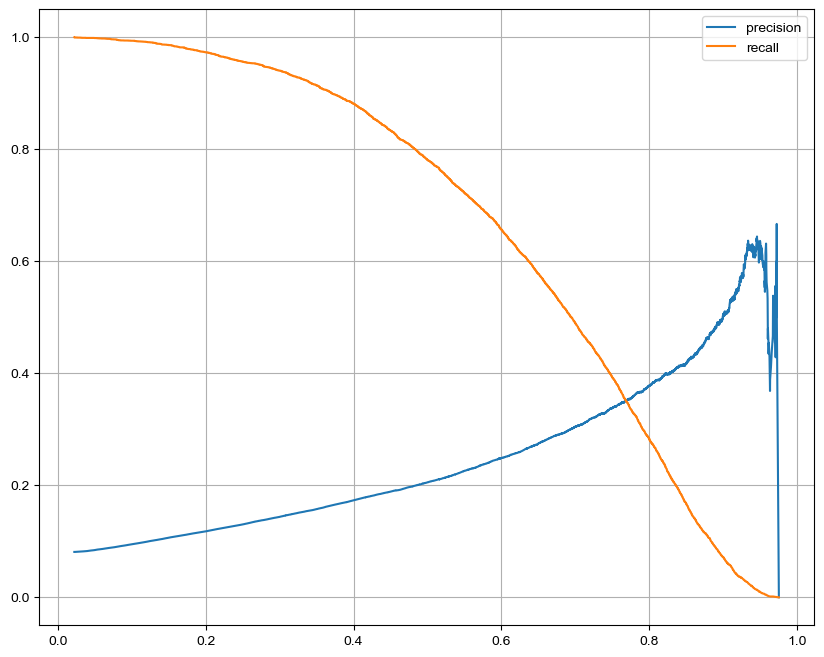

In [131]:
plt.figure(figsize=(10, 8))
predd = model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, predd)
plt.plot(thresholds, precisions[:len(thresholds)], label='precision')
plt.plot(thresholds, recalls[:len(thresholds)], label='recall')
plt.grid(); plt.legend();plt.show()

In [135]:
thresholdChanged = (predd>=0.73).astype(int)

acc = accuracy_score(y_test, thresholdChanged)
pre = precision_score(y_test, thresholdChanged)
re = recall_score(y_test, thresholdChanged)
f1 = f1_score(y_test, thresholdChanged)
aucc = roc_auc_score(y_test, thresholdChanged)

cols = ['memo', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
tmp = []
tmp.append(['lr (under, over, threshold=0.74)', acc, pre, re, f1, aucc])
df = pd.DataFrame(tmp, columns=cols)
df

,memo,accuracy,precision,recall,f1,roc_auc
0,"lr (under, over, threshold=0.74)",0.88098,0.323872,0.434121,0.370979,0.677203
